<a href="https://colab.research.google.com/github/Shukriy/fastai/blob/master/Pneumonia_Image_Dataset_Fastai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

To update packages and the course repo

In [0]:
!curl -s https://course.fast.ai/setup/colab | bash

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


After I run the ImageDataBunch.from_folder() it was printing this --> 


---


> warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
 


---


*The versions of torch and python on my dedicated environment for fastai was causing the problem. There were some package not compatible with each other. I solved my problem installing the right versions of python and pytorch.*
 "

In [0]:
!pip install "torch==1.4" "torchvision==0.5.0"

We import all the necessary packages. We are going to work with the fastai V1 library which sits on top of Pytorch 1.0. The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate

If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller batch size (you'll learn all about what this means during the course), and try again.

In [0]:
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

## Looking at the data

#Deep Learning for Detecting Pneumonia from X-ray Images

Pneumonia is an infection that inflames the air sacs in one or both lungs. The air sacs may fill with fluid or pus (purulent material), causing cough with phlegm or pus, fever, chills, and difficulty breathing. A variety of organisms, including bacteria, viruses and fungi, can cause pneumonia.

Pneumonia can range in seriousness from mild to life-threatening. It is most serious for infants and young children, people older than age 65, and people with health problems or weakened immune systems.

Chest X-ray images helps doctors diagnose pneumonia and determine the extent and location of the infection. 

*path variable points the location the dataset is stored in the GDrive*

In [0]:
path = '/content/drive/My Drive/kaggle/chest_xray'

An ImageDataBunch represents all of the data you need to build a model and there's some factory method which try to make it really easy for you to create that data bunch - a training set, a validation set with images and labels.

This is going to return DataBunch object. In fastai, everything you model with is going to be a DataBunch object. Basically DataBunch object contains 2 or 3 datasets - it contains your training data, validation data, and optionally test data. For each of those, it contains your images and your labels, your texts and your labels, or your tabular data and your labels, or so forth. And that all sits there in this one place(i.e. data).


In [0]:
# np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(),  size=224, bs=bs).normalize(imagenet_stats)

In [24]:
data.classes

['NORMAL', 'PNEUMONIA']

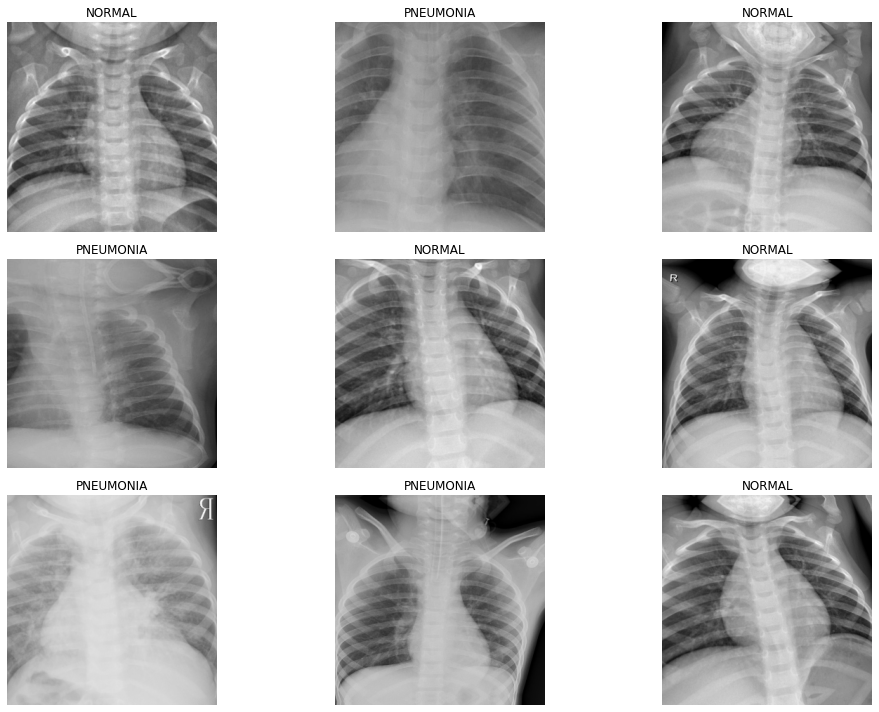

In [74]:
data.show_batch(3, figsize=(15,10))

In [26]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['NORMAL', 'PNEUMONIA'], 2, 9370, 2342)

##Training: resnet34

Now we will start training our model. We will use a convolutional neural network backbone and a fully connected head with a single hidden layer as a classifier. Don't know what these things mean? Not to worry, we will dive deeper in the coming lessons. For the moment you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories (in this case, it will have 37 outputs).

We will train for 4 epochs (4 cycles through all our data).

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [0]:
learn.model

In [1]:
doc(model)

NameError: ignored

In [29]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.371117,0.201008,0.065756,08:22
1,0.210038,0.194487,0.070026,08:17
2,0.152718,0.132269,0.048676,08:19
3,0.133707,0.141742,0.052092,08:23


In [0]:
learn.save('stage-1')

##Results

In [33]:
interpret = ClassificationInterpretation.from_learner(learn)
losses, idxs = interpret.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

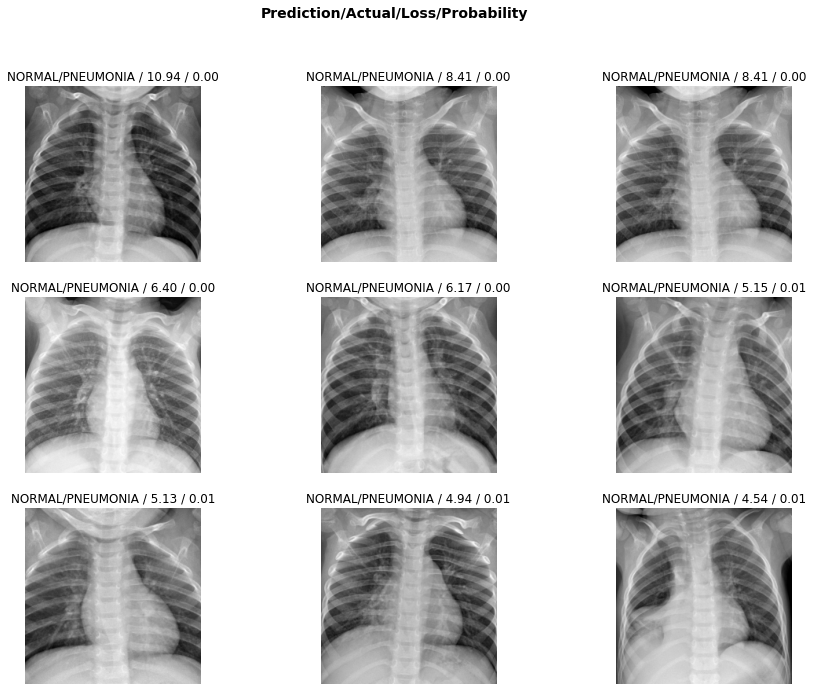

In [38]:
interpret.plot_top_losses(9, figsize=(15,11))

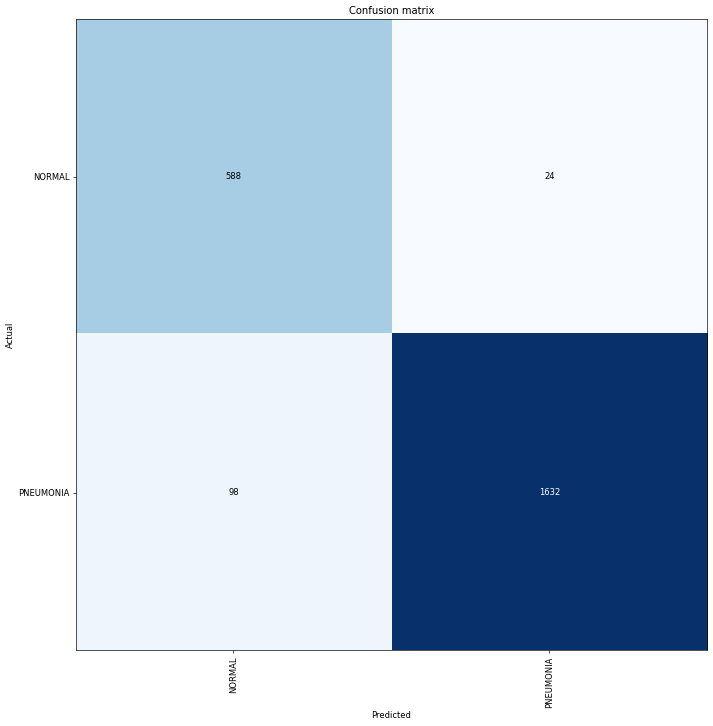

In [40]:
interpret.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [42]:
interpret.most_confused(min_val=2)

[('PNEUMONIA', 'NORMAL', 98), ('NORMAL', 'PNEUMONIA', 24)]

##Unfreezing, fine-tuning, and learning rates

In [0]:
learn.unfreeze()

In [44]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.118919,0.079799,0.026473,08:36


In [0]:
learn.load('stage-1')

In [47]:
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


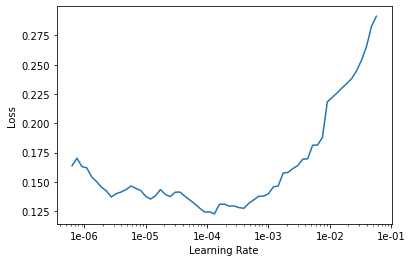

In [48]:
learn.recorder.plot()

In [50]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.084595,0.068685,0.025619,08:33
1,0.081315,0.074811,0.024765,08:33


##Training: resnet50

In [0]:
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(),  size=299, bs=bs//2).normalize(imagenet_stats)

In [54]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


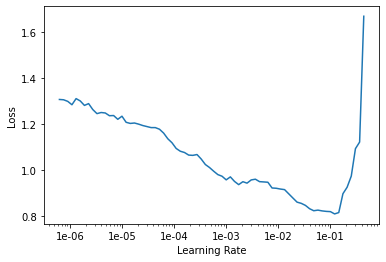

In [55]:
learn.lr_find()
learn.recorder.plot()

In [56]:
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,time
0,0.349460,0.221431,0.064048,11:38
1,0.198046,0.209151,0.067891,11:39
2,0.155730,0.101976,0.032451,11:41
3,0.138305,0.101764,0.037148,11:38
4,0.105185,0.076186,0.029462,11:37
5,0.089351,0.058123,0.022630,11:41
6,0.086882,0.051558,0.017506,11:38
7,0.076631,0.055651,0.022203,11:41


In [0]:
learn.save('stage-1-50')

In [58]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.074057,0.068559,0.028181,12:15
1,0.061711,0.049966,0.021349,12:14
2,0.054035,0.044970,0.017933,12:07


In [0]:
learn.load('stage-1-50');

In [60]:
interp = ClassificationInterpretation.from_learner(learn)

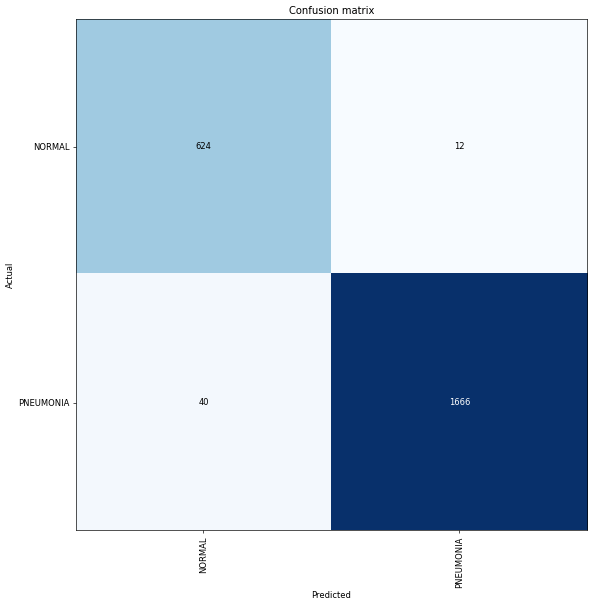

In [61]:
interp.plot_confusion_matrix(figsize=(10,10), dpi=60)

In [62]:
interp.most_confused(min_val=2)

[('PNEUMONIA', 'NORMAL', 40), ('NORMAL', 'PNEUMONIA', 12)]